#**Step 1: Install All the Required Packages**

In [ ]:
!pip install -q accelerate peft bitsandbytes transformers trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.0/348.0 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!python -m bitsandbytes

False

===================================BUG REPORT===================================
/usr/local/lib/python3.11/dist-packages/bitsandbytes/cuda_setup/main.py:166: UserWarning: Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes


  warn(msg)
The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/lib/python3.11/dist-packages/cv2/../../lib64')}
/usr/local/lib/python3.11/dist-packages/bitsandbytes/cuda_setup/main.py:166: UserWarning: /usr/local/lib/python3.11/dist-packages/cv2/../../lib64:/usr/lib64-nvidia did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
The following directories listed in your path were found to be non-existent: {PosixPath('8013'), PosixPath('//172.28.0.1')

#**Step 2: Import All the Required Libraries**

In [ ]:
import os
import torch
import re
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

#**In case of Llama 2, the following prompt template is used for the chat models**

System Prompt (optional) to guide the model


User prompt (required) to give the instruction


Model Answer (required)

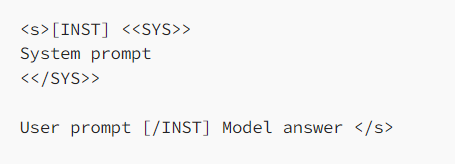

#We will reformat our instruction dataset to follow Llama 2 template.

In [ ]:
import pandas as pd
from datasets import Dataset
def load_data():
    csv_files = ["/content/linux_cmds.csv", "/content/linux_qa.csv"]
    all_data = []

    for file in csv_files:
        if os.path.exists(file):
            df = pd.read_csv(file)
            all_data.append(df)
            print(f"Loaded {file}: {len(df)} rows")
        else:
            print(f"File not found: {file}")

    df = pd.concat(all_data, ignore_index=True)
    df = df.dropna()
    df['input'] = df['input'].str.strip()
    df['output'] = df['output'].str.strip()
    print(f"Total samples: {len(df)}")
    return df

def format_conversation_sample(system_prompt, input_text, output_text):
    """
    Formats a single conversation sample.
    """
    return f"<s>[INST] <<SYS>>\n{system_prompt}\n<</SYS>>\n\n{input_text} [/INST] {output_text} </s>"

def prepare_dataset(df, system_prompt):
    """
    Prepares the dataset for training. Returns original df format for formatting_func.
    """
    # Add system prompt to dataframe for formatting function
    df['system_prompt'] = system_prompt

    # Convert to Hugging Face Dataset
    dataset = Dataset.from_pandas(df)
    return dataset

def formatting_func(example):
    """
    Formats each example for training.
    """
    return format_conversation_sample(
        example['system_prompt'],
        example['input'],
        example['output']
    )

#**Step 3**

1. Load a llama-2-7b-chat-hf model (chat model)
2. Train it on the mlabonne/guanaco-llama2-1k (1,000 samples), which will produce our fine-tuned model Llama-2-7b-chat-finetune

QLoRA will use a rank of 64 with a scaling parameter of 16. We’ll load the Llama 2 model directly in 4-bit precision using the NF4 type and train it for one epoch

In [ ]:
model_name = "NousResearch/Llama-2-7b-chat-hf"

# Fine-tuned model name
new_model = "Llama-2-7b-chat-finetune"

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

#**Step 4:Load everything and start the fine-tuning process**

1. First of all, we want to load the dataset we defined. Here, our dataset is already preprocessed but, usually, this is where you would reformat the prompt, filter out bad text, combine multiple datasets, etc.


2. Then, we’re configuring bitsandbytes for 4-bit quantization.


3. Next, we're loading the Llama 2 model in 4-bit precision on a GPU with the corresponding tokenizer.


4. Finally, we're loading configurations for QLoRA, regular training parameters, and passing everything to the SFTTrainer. The training can finally start!

In [ ]:
# Load dataset
df = load_data()
system_prompt = (
    "You are a Linux instructor AI. You only answer questions related to Linux systems, such as Linux commands, file permissions, system administration, and related topics. "
    "If a question is unrelated to Linux, respond with: 'Sorry, I only answer Linux-related questions.' "
    "Provide beginner-friendly but technically accurate answers."
)

# Prepare dataset for training
train_dataset = prepare_dataset(df, system_prompt)
print(f"Prepared dataset with {len(train_dataset)} samples")

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)


Loaded /content/linux_cmds.csv: 23810 rows
Loaded /content/linux_qa.csv: 300000 rows
Total samples: 323810
Prepared dataset with 323810 samples


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    peft_config=peft_config,
    formatting_func=formatting_func,
    args=training_arguments,
)

Applying formatting function to train dataset:   0%|          | 0/323810 [00:00<?, ? examples/s]

Converting train dataset to ChatML:   0%|          | 0/323810 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/323810 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/323810 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/323810 [00:00<?, ? examples/s]

In [ ]:
trainer.model.save_pretrained(new_model)

In [ ]:
!zip -r /content/merged_linux_model.zip /content/merged_linux_model

  adding: content/merged_linux_model/ (stored 0%)
  adding: content/merged_linux_model/model.safetensors (deflated 19%)
  adding: content/merged_linux_model/generation_config.json (deflated 35%)
  adding: content/merged_linux_model/added_tokens.json (stored 0%)
  adding: content/merged_linux_model/tokenizer.model (deflated 55%)
  adding: content/merged_linux_model/tokenizer_config.json (deflated 72%)
  adding: content/merged_linux_model/config.json (deflated 56%)
  adding: content/merged_linux_model/tokenizer.json (deflated 85%)
  adding: content/merged_linux_model/special_tokens_map.json (deflated 72%)


##**Step 5: Check the plots on tensorboard, as follows**

###**Step 6:Use the text generation pipeline to ask questions like “What is a large language model?” Note that I’m formatting the input to match Llama 2 prompt template.**

In [ ]:
prompt = "how can i give a file the right of execution in linux?"
instruction = (
    "You are a Linux assistant. Only answer questions related to Linux. "
    "If the question is not about Linux, respond with: 'Sorry, I only answer Linux-related questions.'"
)
full_prompt = f"<s>[INST] {instruction}\nQuestion: {prompt} [/INST]"

pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=500)
result = pipe(full_prompt)

output_text = result[0]['generated_text']
if "[/INST]" in output_text:
    answer = output_text.split("[/INST]")[-1].strip()
else:
    answer = output_text.strip()

# Clean unwanted text
answer = re.sub(r"Sorry, I only answer Linux-related questions\.?\s*", "", answer, flags=re.IGNORECASE)
print(answer)

The right of execution for a file in Linux is determined by the file's permissions, which are set using the chmod command.

To give a file the right of execution, you can use the following syntax:
```
chmod +x file
```
This will give the file the execute bit (x) and make it executable.

For example:
```
chmod +x myfile.txt
```
Alternatively, you can also use the `chmod` command with the `-R` option to recursively set the execute bit for all files and directories in a directory and its
